# Braking and OpMode Detection
---

In [1]:
import matplotlib.pyplot as plt

# font
plt.rcParams['font.sans-serif'] = ['Arial']
LABEL_FONT = {
    "fontsize": 12,
    "weight": "bold",
}    

# colors
BLUE = '#2878B5'
LIGHTBLUE = '#9AC9DB'
ORANGE = '#F8AC8C'
RED = '#C82423'
PINK = '#FF8884'
GREY = '#9E9E9E'
DEEPGREEN = '#32B897'
GREEN = '#96CCCB'

plt.rcParams['figure.dpi'] = 300

## 1 Braking detection

The braking detection procedure is performed through the coast-down curve in MOVES which represent the relationship between speed and deceleration of a coasting light-duty vehicle.

In [3]:
import pickle
import numpy as np
from emission.braking import coastDownDec
with open("Z://Data/NEE_Chengdu/traj/processed/gps_20161101_0.pkl", 'rb') as f:
    traj = pickle.load(f)
traj = traj[traj['acc[m/s2]'] < 0].copy()

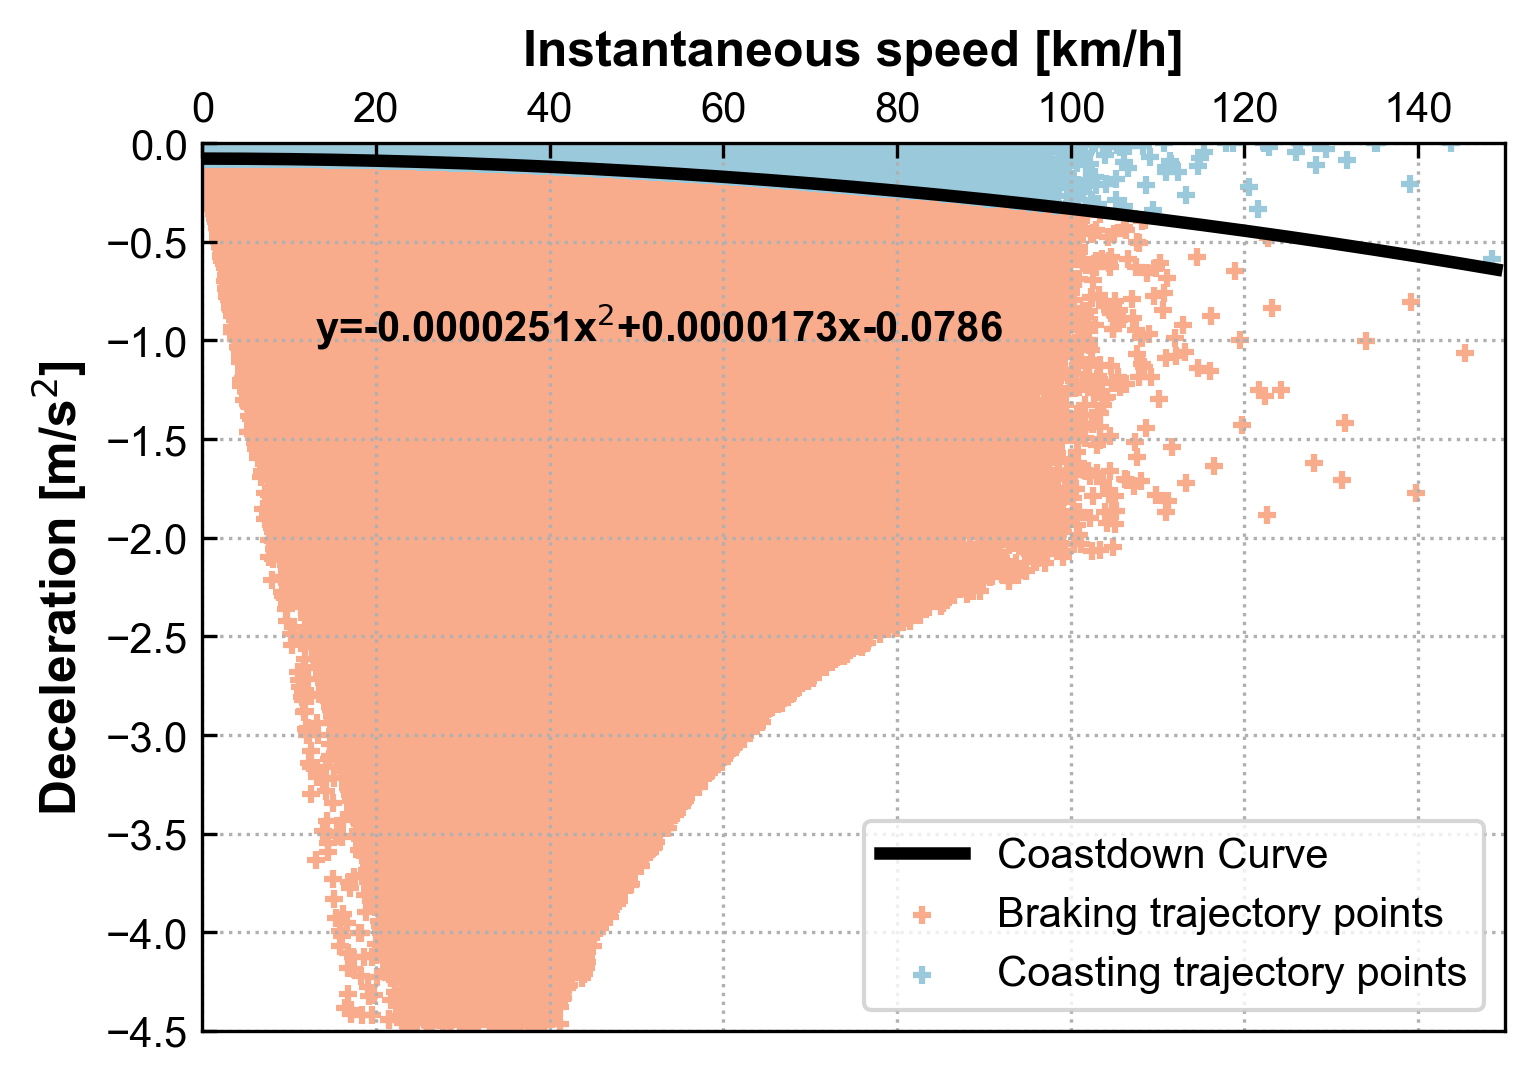

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(5,3.5), constrained_layout=True)
v = np.arange(1, 151, 1)
coastD = np.apply_along_axis(coastDownDec, 0, v)

traj_ = traj.sample(1000000)
braking = traj_[traj_['braking'] == True]
coasting = traj_[traj_['braking'] == False]

ax.plot(coastD, c='k', linewidth=3, label="Coastdown Curve", zorder=20)
ax.scatter(braking['speed[km/h]'], braking['acc[m/s2]'], c=ORANGE, s=20, marker='+', label="Braking trajectory points", zorder=0)
ax.scatter(coasting['speed[km/h]'], coasting['acc[m/s2]'], c=LIGHTBLUE, s=20, marker='+', label="Coasting trajectory points", zorder=0)

ax.set_title("Instantaneous speed [km/h]", fontdict=LABEL_FONT)
ax.tick_params(top=True, bottom=False,
            labeltop=True, labelbottom=False,
            direction='in')
ax.set_ylabel("Deceleration [m/s$^2$]", fontdict=LABEL_FONT)
ax.set_xlim(0, 150)
ax.set_ylim(-4.5, 0)
ax.text(13, -1, "y=-0.0000251x$^2$+0.0000173x-0.0786", fontsize=10, weight="bold", zorder=20)

# ax.spines['bottom'].set_visible(False)
# ax.spines['right'].set_visible(False)
plt.grid(axis="x", linestyle=":", zorder=10)
plt.grid(axis="y", linestyle=":", zorder=10)
plt.legend()
plt.show()

## 2 OpMode Detection

The OpMode (operating mode) is defined in MOVES to represent various driving conditions. The detection methods of braking and OpMode are integrated in the `BWETool` module.

In [3]:
import pandas as pd
traj = pd.read_csv("./data/traj/sample_mapmatched.csv")
traj.head()

,vehID,orderID,tripID,time[s],lon,lat,dist[km],interval[s],speed[km/h],acc[m/s2],ele[m],grade[D],VSP[kW/t],osmid
0,0.0,0.0,0.0,1.477969e+09,104.070087,30.731888,0.007380,1.0,32.384280,-3.726805,466.000,0.000000,-34.847050,NaN
1,0.0,0.0,0.0,1.477969e+09,104.070087,30.731822,0.004364,1.0,20.712196,-1.527181,466.000,0.068639,-9.830153,NaN
2,0.0,0.0,0.0,1.477969e+09,104.070082,30.731783,0.003779,1.0,15.737670,0.747944,465.700,0.055508,3.349933,NaN
3,0.0,0.0,0.0,1.477969e+09,104.070070,30.731750,0.005502,1.0,18.587265,2.996978,465.490,0.026709,17.738155,NaN
4,0.0,0.0,0.0,1.477969e+09,104.070051,30.731704,0.009463,1.0,29.423483,5.278276,465.343,0.042550,50.495445,NaN


In [4]:
from emission import BWETool

bwe = BWETool()
traj = bwe.brakingDetect(traj)
traj = bwe.OpModeDetect(traj)
traj.head()

,vehID,orderID,tripID,time[s],lon,lat,dist[km],interval[s],speed[km/h],acc[m/s2],ele[m],grade[D],VSP[kW/t],osmid,braking,OpModeID
0,0.0,0.0,0.0,1.477969e+09,104.070087,30.731888,0.007380,1.0,32.384280,-3.726805,466.000,0.000000,-34.847050,NaN,True,0
1,0.0,0.0,0.0,1.477969e+09,104.070087,30.731822,0.004364,1.0,20.712196,-1.527181,466.000,0.068639,-9.830153,NaN,True,11
2,0.0,0.0,0.0,1.477969e+09,104.070082,30.731783,0.003779,1.0,15.737670,0.747944,465.700,0.055508,3.349933,NaN,False,13
3,0.0,0.0,0.0,1.477969e+09,104.070070,30.731750,0.005502,1.0,18.587265,2.996978,465.490,0.026709,17.738155,NaN,False,16
4,0.0,0.0,0.0,1.477969e+09,104.070051,30.731704,0.009463,1.0,29.423483,5.278276,465.343,0.042550,50.495445,NaN,False,16


In [5]:
traj.to_csv("./data/traj/sample_processed.csv", index=False)

## 3 Braking decel distribution

In [4]:
import pandas as pd
dist = pd.read_excel("./data/brake/brake_decel_dist.xlsx", sheet_name="Brake Decel Dist MPH")
dist.columns = ['decel', 'Chengdu', 'LA rural', 'LA urban', 'Kansas', 'MOVES Avg']
dist = dist.iloc[:-1]
dist

,decel,Chengdu,LA rural,LA urban,Kansas,MOVES Avg
0,1.0,0.389913,0.271,0.371,0.545,0.395
1,2.0,0.265177,0.279,0.263,0.263,0.269
2,3.0,0.148387,0.202,0.179,0.128,0.170
3,4.0,0.086027,0.122,0.102,0.046,0.090
4,5.0,0.050749,0.082,0.056,0.013,0.050
5,6.0,0.029495,0.024,0.016,0.003,0.014
6,7.0,0.016102,0.010,0.006,0.001,0.006
7,8.0,0.008353,0.004,0.003,0.000,0.002
8,9.0,0.003949,0.003,0.002,0.000,0.002
9,10.0,0.001848,0.001,0.001,0.000,0.001


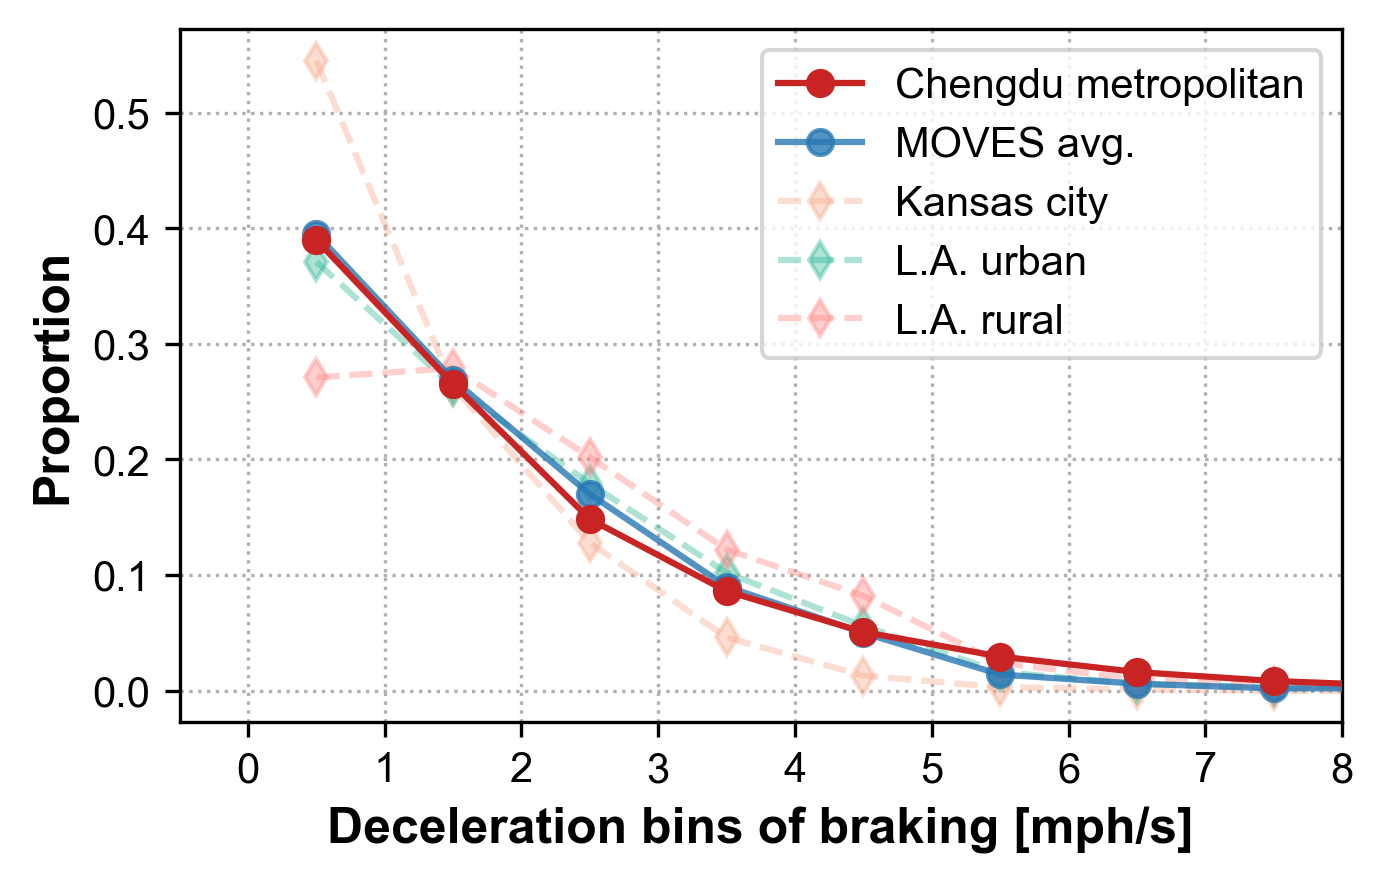

In [11]:
fig, ax = plt.subplots(1,1,figsize=(5,3))

ax.plot(dist['decel'], dist['Chengdu'], color=RED, linestyle='-', marker='o', alpha=1, zorder=40, label="Chengdu metropolitan")
ax.plot(dist['decel'], dist['MOVES Avg'], color=BLUE, linestyle='-', marker='o', alpha=0.8, zorder=30, label="MOVES avg.")
ax.plot(dist['decel'], dist['Kansas'], color=ORANGE, linestyle='--', marker='d', alpha=0.4, zorder=20, label="Kansas city")
ax.plot(dist['decel'], dist['LA urban'], color=DEEPGREEN, linestyle='--', marker='d', alpha=0.4, zorder=20, label="L.A. urban")
ax.plot(dist['decel'], dist['LA rural'], color=PINK, linestyle='--', marker='d', alpha=0.4, zorder=20, label="L.A. rural")
ax.set_xticks(np.arange(0,15,1)+0.5, np.arange(0,15,1))
ax.set_xlim(0, 8.5)
ax.set_xlabel("Deceleration bins of braking [mph/s]", fontdict=LABEL_FONT)
ax.set_ylabel("Proportion", fontdict=LABEL_FONT)

plt.legend()
plt.grid(linestyle=":")
plt.show()